# Importing Libraries & Df

In [3]:
# !pip install gensim

  Using cached gensim-4.0.1-cp38-cp38-win_amd64.whl (23.9 MB)
  Using cached smart_open-5.0.0-py3-none-any.whl (56 kB)
  Attempting uninstall: Cython
    Found existing installation: Cython 0.29.23
    Uninstalling Cython-0.29.23:
      Successfully uninstalled Cython-0.29.23


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import scipy as sp
import sklearn
import sys
import os

import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
import nltk
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from nltk import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy import linalg

# !pip install gensim 완료
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
import pickle
import string
import time


In [3]:
path = r'C:\Users\MinSeong\Desktop\수업\비즈니스 텍마\Term Proj'
os.chdir(path)
df = pd.read_csv('diabetes.csv',parse_dates=["date"],index_col='Unnamed: 0')

In [164]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51573 entries, 0 to 8507
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        51526 non-null  object        
 1   content      47803 non-null  object        
 2   writer       51526 non-null  object        
 3   date         51526 non-null  datetime64[ns]
 4   view         51526 non-null  object        
 5   likes        51526 non-null  float64       
 6   no_comments  51526 non-null  float64       
 7   board        51573 non-null  object        
 8   url          51573 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 3.9+ MB


# 중복, 결측치 Handling

중복 제거

In [165]:
# 중복 title 제거
df = df.drop_duplicates(['title'])
df.reset_index(drop = True,inplace = True)

In [166]:
#content 중복인 행 제거 
df = df.drop_duplicates(['content'])
df.reset_index(drop = True,inplace = True)
df.head()

,title,content,writer,date,view,likes,no_comments,board,url
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...


In [167]:
# 결측치 행 (한개) 제거
df = df.dropna(axis = 0)
df

,title,content,writer,date,view,likes,no_comments,board,url
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...
...,...,...,...,...,...,...,...,...,...
33999,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...
34000,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...
34001,\n 당뇨병이 있을 경우 운동 시 주의사항~\n,제가 운동을 자주 하는 편입니다.,\n 천국\n,2010-08-25 16:28:00,330,0.0,10.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...
34002,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...


In [168]:
df.info()
#결측치 없음. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34003 entries, 0 to 34003
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   title        34003 non-null  object        
 1   content      34003 non-null  object        
 2   writer       34003 non-null  object        
 3   date         34003 non-null  datetime64[ns]
 4   view         34003 non-null  object        
 5   likes        34003 non-null  float64       
 6   no_comments  34003 non-null  float64       
 7   board        34003 non-null  object        
 8   url          34003 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(6)
memory usage: 2.6+ MB


# Quick Date Column check

In [169]:
# 연도 컬럼 전처리
df["year"] = df['date'].dt.year
df["month"] = df['date'].dt.month
df["hour"] = df['date'].dt.hour

df.head()

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16


C:\Users\MinSeong\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '2010'),
  Text(1, 0, '2011'),
  Text(2, 0, '2012'),
  Text(3, 0, '2013'),
  Text(4, 0, '2014'),
  Text(5, 0, '2015'),
  Text(6, 0, '2016'),
  Text(7, 0, '2017'),
  Text(8, 0, '2018'),
  Text(9, 0, '2019'),
  Text(10, 0, '2020'),
  Text(11, 0, '2021')])

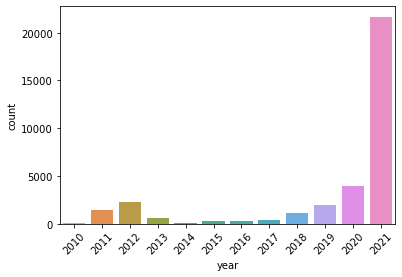

In [170]:
# 수집한 데이터 연도별 게시글
sns.countplot(df['year'])
plt.xticks(rotation = 45)

C:\Users\MinSeong\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, '1'),
  Text(1, 0, '2'),
  Text(2, 0, '3'),
  Text(3, 0, '4'),
  Text(4, 0, '5'),
  Text(5, 0, '6'),
  Text(6, 0, '7'),
  Text(7, 0, '8'),
  Text(8, 0, '9'),
  Text(9, 0, '10'),
  Text(10, 0, '11'),
  Text(11, 0, '12')])

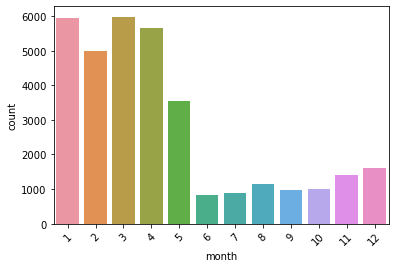

In [171]:
# 수집한 데이터 월별 게시글
sns.countplot(df['month'])
plt.xticks(rotation = 45)

1~5월에 압도적으로 많은 게시글.. 

이라고 오해할 수 있지만 그렇지 않음.

2021년이 가장 게시글 많은 해이며 본 프로젝트는 2021 년 5월 기준으로 수집한 데이터이기 때문. 

C:\Users\MinSeong\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

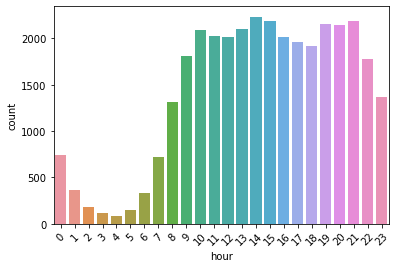

In [172]:
# 수집한 데이터 월별 게시글
sns.countplot(df['hour'])
plt.xticks(rotation = 45)

이는 그저 밤, 낮 차이로 발생한 결과. 

시간 데이터만으로는 유의미한 인사이트 찾아낼 수 없었음.

# Cleaning Text

In [173]:
def clean_text(text):
    text = re.sub('http[s]?://\S+', '', text) # http url 제거
    text = re.sub('\S*@\S*\s?', '', text) #
    text = re.sub(r'\[.*?\]', '', text) # 
    text = re.sub(r'\w*\d\w*', '', text) # 숫자 포함하는 텍스트 제거
    text = re.sub('[?.,;:|\)*~"`’!\-_+<>@\#$%&-=#}※]', ' ', text)#특수문자 이모티콘 제거.
    text = re.sub("\n", '', text) #개행문자 제거
    text = re.sub("\r", '', text) #개행문자 제거
    text = re.sub("\xa0", '', text) #개행문자 제거
    text = re.sub(r'Copyright .* rights reserved', '', text) # "Copyright all rights reserved" 제거
    return text
# content   
df['text_content'] = pd.DataFrame(df.content.apply(lambda x: clean_text(x)))

#title
df['text_title'] = pd.DataFrame(df.title.apply(lambda x: clean_text(x)))

# seperate sentences

In [174]:
import kss
# content

df['content_sep'] = df['text_content'].apply(lambda x: kss.split_sentences(x))
df['content_sep'].head()


0    [혈당재기 직전 운동 마친 저녁 식사  후가  마시고  앉아있다가 재니  나왔는데 ...
1    [관리를 못해 당화혈색소가   됐더라구요ㅜ원래먹던약이 직듀오서방정   디아미크롱서방...
2    [어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...
3    [내의지와는 전혀상관없이 체중이 빠져버렸네요, 마지노선인  사수하기 위해     먹...
4    [안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ, 높을거라 생각은 했지만  후  후 ...
Name: content_sep, dtype: object

In [175]:
# title
df['title_sep'] = df['text_title'].apply(lambda x: kss.split_sentences(x))
df['title_sep'].head()

0                      [혈당변화]
1        [약 부작용이 있으면 어떻게 하나요]
2    [안녕하세요, 당뇨기계 추천 받고자 합니다]
3         [체중과의 사투를 벌이고 있네요ㅠ]
4                       [쌀국수]
Name: title_sep, dtype: object

# 띄어쓰기, 맞춤법 수정

In [176]:
def space(docu):
    docu_spaced = []
    for sent in docu:
        docu_spaced.append(spacing(sent))
    return docu_spaced

In [177]:
from pykospacing import spacing

docu = df['content_sep'].loc[0]
docu_spaced = []
for sent in docu:
    docu_spaced.append(spacing(sent))

띄어쓰기 수정

In [178]:
#띄어쓰기
from pykospacing import spacing
def space(docu):
    docu_spaced = []
    for sent in docu:
        docu_spaced.append(spacing(sent))
    return docu_spaced
    
sys.setrecursionlimit(3000)

begin = time.time()

df['content_sep']  = df['content_sep'].apply(lambda x: space(x))
df['content_sep'].head()

end = time.time()
print(np.round((end - begin)/60),"분 소요")

56.0 분 소요


맞춤법 수정

In [179]:
#맞춤법
import time
begin = time.time()


from hanspell import spell_checker
def spell(docu):
    try:
        docu_spelled = []
        for sent in docu:
            docu_spelled.append(spell_checker.check(sent).checked)
    except:
        docu_spelled = docu
    return docu_spelled
        
df['content_p'] = df['content_sep'].apply(lambda x: spell(x))

end = time.time()
print(np.round((end - begin)/60),"분 소요")

97.0 분 소요


In [180]:
# title 도 띄어쓰기, 맞춤법 수정
begin = time.time()

docu = df['title_sep'].loc[0]
docu_spaced = []
for sent in docu:
    docu_spaced.append(spacing(sent))
    


#띄어쓰기
df['title_sep']  = df['title_sep'].apply(lambda x: space(x))
df['title_sep'].head()

#맞춤법

df['title_p'] = df['title_sep'].apply(lambda x: spell(x))



end = time.time()

print(np.round((end - begin)/60),"분 소요")

31.0 분 소요


In [181]:
# 맞춤법, 띄어쓰기 수정한 tect
#df.to_csv('preprocessed_df_pre_형태소.csv')

In [182]:
df.head()

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화]
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],[관리를 못해 당화혈 색소가 됐더라고 요ㅜ원래 먹던 약이 직 듀오 서방 정 디 아미...,[약 부작용이 있으면 어떻게 하나요]
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]",[어머니가 오랫동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 채혈 ...,"[안녕하세요, 당뇨 기계 추천받고 자 합니다]"
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[내 의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡...",[체중과의 사투를 벌이고 있네요ㅠ]
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수]


# 숫자 제거

In [ ]:
# title
p=re.compile("[0-9]+")
df['title_p'] = df['title_p'].apply(lambda x: p.sub(" ",x[0]))

#content
p=re.compile("[0-9]+")
df['content_p'] = df['content_p'].apply(lambda x: p.sub(" ",x[0]))


In [183]:
df['title_p'] # 리스트 제대로 되었는지 확인

0                          [혈당 변화]
1             [약 부작용이 있으면 어떻게 하나요]
2        [안녕하세요, 당뇨 기계 추천받고 자 합니다]
3              [체중과의 사투를 벌이고 있네요ㅠ]
4                            [쌀국수]
                   ...            
33999        [이소라 다이어트 체조 그리고 혈당계]
34000                  [나나의 입원 일기]
34001       [당뇨병이 있을 경우 운동 시 주의사항]
34002                  [나나의 입원 일기]
34003               [식단을 짜야 한다 얼른]
Name: title_p, Length: 34003, dtype: object

In [187]:

# pkl_name = 'preprocessed_df_pre_형태소'
# with open(pkl_name,'wb') as fw:
#   pickle.dump(df,fw)

 형태소 쪼개기전 pickle loading

In [3]:
with open('preprocessed_df_pre_형태소','rb') as fr:
  df = pickle.load(fr)
df

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화]
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],[관리를 못해 당화혈 색소가 됐더라고 요ㅜ원래 먹던 약이 직 듀오 서방 정 디 아미...,[약 부작용이 있으면 어떻게 하나요]
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]",[어머니가 오랫동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 채혈 ...,"[안녕하세요, 당뇨 기계 추천받고 자 합니다]"
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[내 의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡...",[체중과의 사투를 벌이고 있네요ㅠ]
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33999,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당계]
34000,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],[나나의 입원 일기]
34001,\n 당뇨병이 있을 경우 운동 시 주의사항~\n,제가 운동을 자주 하는 편입니다.,\n 천국\n,2010-08-25 16:28:00,330,0.0,10.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,16,제가 운동을 자주 하는 편입니다,당뇨병이 있을 경우 운동 시 주의사항,[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항],[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항]
34002,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],[새벽 반에 일어나],[나나의 입원 일기]


# 형태소 분석

In [14]:
#!pip install konlpy
from konlpy.tag import Okt

In [42]:
with open('preprocessed_df_pre_형태소','rb') as fr:
  df = pickle.load(fr)
df

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화]
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],[관리를 못해 당화혈 색소가 됐더라고 요ㅜ원래 먹던 약이 직 듀오 서방 정 디 아미...,[약 부작용이 있으면 어떻게 하나요]
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]",[어머니가 오랫동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 채혈 ...,"[안녕하세요, 당뇨 기계 추천받고 자 합니다]"
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[내 의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡...",[체중과의 사투를 벌이고 있네요ㅠ]
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33999,\n [웃짜 8월25일 -7일차 71.6kg] 이소라 다이어트 ...,≫목표몸무게/현재몸무게 : 54kg / 71.6(표준체중 + 17.6kg),\n 웃짜\n,2010-08-25 22:51:00,171,0.0,3.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,22,≫목표몸무게 현재몸무게 표준체중,이소라 다이어트 체조 그리고 혈당기,[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당기],[≫ 목표 몸무게 현재 몸무게 표준체중],[이소라 다이어트 체조 그리고 혈당계]
34000,\n 8/25 나나의 입원일기 3일째(500->140)\n ...,"입원 1,2일째에는...",\n 나나\n,2010-08-25 19:23:00,210,0.0,5.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,19,입원,나나의 입원일기,[입원],[나나의 입원일기],[입원],[나나의 입원 일기]
34001,\n 당뇨병이 있을 경우 운동 시 주의사항~\n,제가 운동을 자주 하는 편입니다.,\n 천국\n,2010-08-25 16:28:00,330,0.0,10.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,16,제가 운동을 자주 하는 편입니다,당뇨병이 있을 경우 운동 시 주의사항,[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항],[제가 운동을 자주 하는 편입니다],[당뇨병이 있을 경우 운동 시 주의사항]
34002,\n 8/23 나나의 입원일기 1일째\n,새벽 6시 반에 일어나,\n 나나\n,2010-08-25 09:49:00,214,0.0,6.0,exerc,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2010,8,9,새벽 반에 일어나,나나의 입원일기,[새벽 반에 일어나],[나나의 입원일기],[새벽 반에 일어나],[나나의 입원 일기]


In [43]:
from konlpy.tag import Okt  
okt=Okt()  

def pos_tagging(sent_list):
    sent_tokens=[]
    for sentence in sent_list:
        sent_tokens.append(okt.pos(sentence))
    return(sent_tokens)

df['content_p']=df['content_p'].apply(lambda x: pos_tagging(x))
df['title_p']=df['title_p'].apply(lambda x: pos_tagging(x))



KeyboardInterrupt: 

In [ ]:
df.head()

In [ ]:

# 명사, 동사, 형용사만 추출. 어미, 조사등은 배제.

def n_v_a_selection(sent_list):    
    sent_tokens=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if (token[1]=='Noun' or token[1]=='Adjective' or token[1]=='Verb'):
                new_sent.append(token)
        sent_tokens.append(new_sent)
    return(sent_tokens)

df['content_p']=df['content_p'].apply(lambda x: n_v_a_selection(x))
df['title_p']=df['title_p'].apply(lambda x: n_v_a_selection(x))

In [ ]:

# 표제어 추출
#pip install soylemma 
from soylemma import Lemmatizer

lemmatizer = Lemmatizer()

def lemma(sent_list):
    sent_stems=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if (token[1]=='Adjective')|(token[1]=='Verb'): #명사는 필요 없음.
                stem_result=lemmatizer.lemmatize(token[0])
                if len(stem_result)!=0:              # 빈 리스트가 반환되는 경우 제외
                    new_sent.append(stem_result[0])  # 결과 중 맨 앞에 것만 추가
            else:
                new_sent.append(token)
                    
        sent_stems.append(new_sent)
    return(sent_stems)
            
df['content_p']=df['content_p'].apply(lambda x: lemma(x))
df['title_p']=df['title_p'].apply(lambda x: lemma(x))

In [ ]:
df['content_p']

In [35]:
# #stopwords 전에 저장
# pkl_name = 'preprocessed_df_pre_stopwords'
# with open(pkl_name,'wb') as fw:
#   pickle.dump(df,fw)


# stop words 지우기 check point

In [123]:

with open('preprocessed_df_pre_stopwords','rb') as fr:
  df = pickle.load(fr)
df.reset_index(drop = True, inplace = True)

In [122]:
#df['content_p'].loc[22209]

# Stopwords 제거.



In [124]:
#분석시에는 추가
def rem_stopwords(sent_list):
    stopwords=[('이','Noun'), ('거','Noun'),('오','Noun'), ('것','Noun'),('있다','Adjective'),('있다', 'Verb'),\
               ('하다','Adjective'),('하다','Verb'),('보다','Verb'),('아니다','Adjective'),('내', 'Noun'),('안녕', 'Noun'),\
              ('요', 'Noun'),('되다', 'Verb'),('제', 'Noun'),('이다', 'Adjective'),\
              ('같다', 'Adjective'),('때', 'Noun'),('저', 'Noun'),('좀', 'Noun')]
    sent_stop=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            if token not in stopwords:
                new_sent.append(token)
        sent_stop.append(new_sent)
    return(sent_stop)
   
df['content_p']=df['content_p'].apply(lambda x: rem_stopwords(x))
df['title_p']=df['title_p'].apply(lambda x: rem_stopwords(x))

In [125]:

# pos 태그 제거
def rem_tag(sent_list):
    sent_final=[]
    for sentence in sent_list:
        new_sent=[]
        for token in sentence:
            new_sent.append(token[0])
        sent_final.append(new_sent)
    return(sent_final)

#review_df['comment_n']=review_df['comment_n'].apply(lambda x: rem_tag(x))

   
df['content_p']=df['content_p'].apply(lambda x: rem_tag(x))
df['title_p']=df['title_p'].apply(lambda x: rem_tag(x))

In [126]:
df['content_p']

0        [[혈당, 재기, 직전, 운동, 마치다, 저녁, 식사, 후, 말다, 앉다, 재니, ...
1        [[관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디...
2        [[어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈...
3        [[의지, 전혀, 체중, 빠지다, 버리다], [마지노선, 사수, 위해, 먹다, 잡곡...
4        [[점심, 쌀국수, 먹다], [높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복...
                               ...                        
33998                         [[목표, 몸무게, 현재, 몸무게, 표준, 체중]]
33999                                               [[입원]]
34000                                    [[운동, 자주, 편입, 니]]
34001                                        [[새벽, 반, 일다]]
34002                         [[목표, 몸무게, 현재, 몸무게, 표준, 체중]]
Name: content_p, Length: 34003, dtype: object

In [127]:
# one list로 만들기

def one_word_list(sent_list):
    one_list=[]
    for sentence in sent_list:
        one_list.extend(sentence)
    return(one_list)


   
df['content_p']=df['content_p'].apply(lambda x: one_word_list(x))
df['title_p']=df['title_p'].apply(lambda x: one_word_list(x))


In [128]:
df['content_p']

0        [혈당, 재기, 직전, 운동, 마치다, 저녁, 식사, 후, 말다, 앉다, 재니, 나...
1        [관리, 당화, 혈, 색소, 더, 원래, 먹다, 약, 직, 듀오, 서방, 정, 디,...
2        [어머니, 당뇨, 가지, 계시다, 기계, 오래되다, 바꾸다, 드리다, 싶다, 채혈,...
3        [의지, 전혀, 체중, 빠지다, 버리다, 마지노선, 사수, 위해, 먹다, 잡곡, 밥...
4        [점심, 쌀국수, 먹다, 높다, 생각, 후, 후, 쌀국수, 거리, 두기, 공복, 어렵다]
                               ...                        
33998                           [목표, 몸무게, 현재, 몸무게, 표준, 체중]
33999                                                 [입원]
34000                                      [운동, 자주, 편입, 니]
34001                                          [새벽, 반, 일다]
34002                           [목표, 몸무게, 현재, 몸무게, 표준, 체중]
Name: content_p, Length: 34003, dtype: object

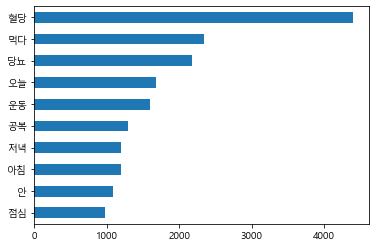

In [129]:

# Word Frequency - title

total_word=[]
for i in range(len(df)):
    total_word.extend(df.loc[i,'title_p'])

pd.Series(total_word).value_counts().head(10)

# 한글 폰트 사용
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#pd.Series(total_word).value_counts().head(10).plot(kind='bar')
#pd.Series(total_word).value_counts().head(10).plot(kind='barh')
pd.Series(total_word).value_counts().head(10).plot(kind='barh').invert_yaxis()


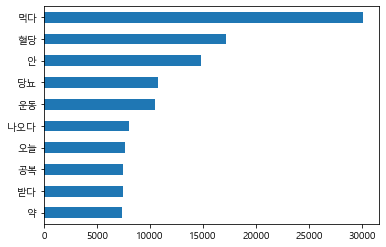

In [130]:

# Word Frequency - content

total_word=[]
for i in range(len(df)):
    total_word.extend(df.loc[i,'content_p'])

pd.Series(total_word).value_counts().head(10)

# 한글 폰트 사용
from matplotlib import font_manager, rc

font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

#pd.Series(total_word).value_counts().head(10).plot(kind='bar')
#pd.Series(total_word).value_counts().head(10).plot(kind='barh')
pd.Series(total_word).value_counts().head(10).plot(kind='barh').invert_yaxis()


In [131]:
# word to a str
joined = df['content_p'].apply(lambda x: " ".join(x))
wc_input = joined.sum()

(-0.5, 799.5, 599.5, -0.5)

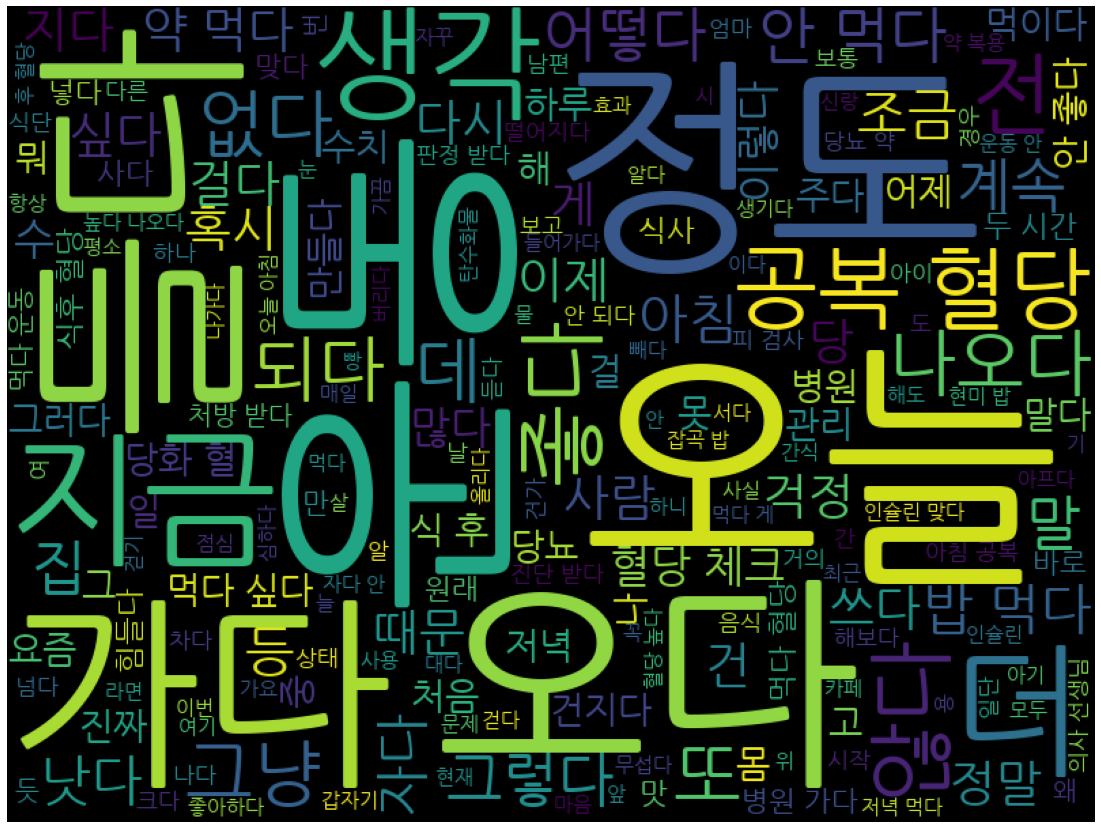

In [132]:
#!pip install wordcloud
from wordcloud import WordCloud

cloud = WordCloud(font_path="NanumGothic.ttf",
                  width=800, height=600).generate(wc_input)

plt.figure(figsize=(20, 15))
plt.imshow(cloud)
plt.axis('off')

오늘 저 같다 등 빼도 되지 않을까.. 일단 감성 분석때 또 모르니 놔둬보자.

~~ 같다라는 말을 정말 많이 씀. 


In [20]:
df.head()

,title,content,writer,date,view,likes,no_comments,board,url,year,month,hour,text_content,text_title,content_sep,title_sep,content_p,title_p
0,\n 10분만에 혈당변화\n,\n혈당재기 직전 운동 마친 저녁 식사 2시간 후가 176이었는데물한잔 마시고 10...,\n 치치타\n,2021-05-14 21:21:00,208,0.0,9.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,21,혈당재기 직전 운동 마친 저녁 식사 후가 마시고 앉아있다가 재니 나왔는데 이...,혈당변화,[혈당 재기 직전 운동 마친 저녁 식사 후가 마시고 앉아 있다가 재니 나왔는데 이럴...,[혈당 변화],"[[마, 말, 앉, 있, 나, 이, 있], [자, 씻, 않, 떨, 있]]",[[]]
1,\n 약 부작용이 있으면 어떻게 하나요??\n,\n관리를 못해 당화혈색소가 8.9가 됐더라구요ㅜ원래먹던약이 직듀오서방정 10/10...,\n 긍정왕썰\n,2021-05-14 18:42:00,157,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,관리를 못해 당화혈색소가 됐더라구요ㅜ원래먹던약이 직듀오서방정 디아미크롱서방정...,약 부작용이 있으면 어떻게 하나요,[관리를 못해 당화혈 색소가 됐더라구 요ㅜ원래 먹던 약이 직 듀오 서방 정 디아미크...,[약 부작용이 있으면 어떻게 하나요],"[[됐, 먹, 새, 되, 바, 심, 오, 쓰, 없, 그, 모, 쓰, 참, 힘]]","[[있, 어]]"
2,\n 안녕하세요~ 당뇨기계 추천 받고자 합니다\n,\n어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,\n 티타2\n,2021-05-14 18:30:00,101,0.0,8.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,18,어머니가 오래동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈 ...,안녕하세요 당뇨기계 추천 받고자 합니다,[어머니가 오래 동안 당뇨를 가지고 계신데 기계가 오래되어 바꿔 드리고 싶은데 체혈...,"[안녕하세요, 당뇨기계 추천 받고 자 합니다]","[[계, 오, 바, 드, 싶, 아, 않], [], [재, 날, 자, 몰]]","[[안], [받]]"
3,\n 체중과의 사투를 벌이고 있네요ㅠ\n,\n확진후8개월만에 10키로가 내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선...,\n 천왕봉\n,2021-05-14 17:27:00,221,0.0,16.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,17,내의지와는 전혀상관없이 체중이 빠져버렸네요 ​마지노선인 사수하기 위해 ...,체중과의 사투를 벌이고 있네요ㅠ,"[내의지와는 전혀 상관없이 체중이 빠져버렸네요, 마지노선인 사수하기 위해 먹던 잡곡...",[체중과의 사투를 벌이고 있네요ㅠ],"[[상, 빠, 버], [먹, 올, 먹, 지, 모, 되, 먹, 되, 싶, 맞, 힘]]",[[있]]
4,\n 쌀국수\n,\n안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 ㅠㅠ1시간 후...,\n 희뿡2\n,2021-05-14 16:02:00,107,0.0,4.0,all_couns,https://cafe.naver.com/ArticleRead.nhn?clubid=...,2021,5,16,안녕들하세요^^점심에 쌀국수를 먹었네요 ㅋㅋ높을거라 생각은 했지만 후 후 ^^...,쌀국수,"[안녕들 하세요 점심에 쌀국수를 먹었네요 ㅋㅋ, 높을 거라 생각은 했지만 후 후 쌀...",[쌀국수],"[[먹], [높, 어]]",[[]]


preprocessing 완료.

In [134]:
##df.to_csv('preprocessed_df.csv')
# with open("preprocessed_df","wb") as fw:
#     pickle.dump(df,fw)


In [6]:
import pandas as pd
df = pd.read_csv('preprocessed_df.csv')

In [11]:
df.loc[6,['text_content','content_p']]

text_content     후반  당뇨  년차  하는 합병증 검사에서  늘 별이상 없었는데이번에 병원을  한...
content_p       ['후반', '당뇨', '연차', '합병증', '검사', '늘', '별', '이상'...
Name: 6, dtype: object